## Agents

[This is the agents section](https://microsoft.github.io/autogen/stable//user-guide/agentchat-user-guide/tutorial/agents.html#assistant-agent)

Autogen Agentchat provides various agents that are capable of **responding** differently to user inputs

The common attributes and methods of the agents are
1. name
2. description
3. run (coroutine) - use await in jupyter :
   - A method that runs the **task** given to the agent.
   - Task is given as a **string** or **list of messages**.
   - Returns a **TaskResult**
   - Agents are expected to be stateful and this method is expected to be called with new messages, not complete history.
   - Refer to below img on what **stateful** means. So effectively, only new messages are passed to the run method as Agents remember the history themselves.
4. run_stream : Same as run but
   - returns an iterator of messages (BaseAgentEvent or BaseChatMessage).
   - Followed by TaskResult as the last item.

### <u>Comment on statefulness of agents</u>

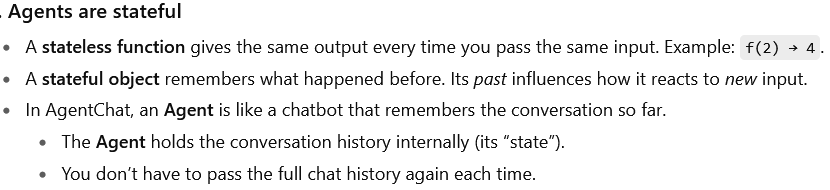

## 1) <u>Assistant Agent</u>

Uses LLMs and has ability to use Tools.

**note**: This is a very general agent for educational purposes to understand all options. Ideally, once you understand then implement your own agent via [Custom Agent](https://microsoft.github.io/autogen/stable//user-guide/agentchat-user-guide/custom-agents.html)

### 1.1) <u>Base Assistant Agent ex (already seen in quickstart. Pasting for completion purposes - skip if revising).</u>

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4.1-nano",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [3]:
result = await agent.run(task="Find information on AutoGen")
type(result)

autogen_agentchat.base._task.TaskResult

In [10]:
# attributes of this object (except dunder attrs)
[i for i in dir(result) if i.find("__") == -1]

['_abc_impl',
 '_calculate_keys',
 '_copy_and_set_values',
 '_get_value',
 '_iter',
 '_setattr_handler',
 'construct',
 'copy',
 'dict',
 'from_orm',
 'json',
 'messages',
 'model_computed_fields',
 'model_config',
 'model_construct',
 'model_copy',
 'model_dump',
 'model_dump_json',
 'model_extra',
 'model_fields',
 'model_fields_set',
 'model_json_schema',
 'model_parametrized_name',
 'model_post_init',
 'model_rebuild',
 'model_validate',
 'model_validate_json',
 'model_validate_strings',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'schema',
 'schema_json',
 'stop_reason',
 'update_forward_refs',
 'validate']

In [12]:
# Use asyncio.run(agent.run(...)) when running in a script.
# result = await agent.run(task="Find information on AutoGen")
print(result.messages)

[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 15, 59, 55, 356894, tzinfo=datetime.timezone.utc), content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=32), metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 0, 2, 233689, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_Xuoy6QHgToaMU85Y7VXJNH2r', arguments='{"query": "AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 0, 2, 233689, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_Xuoy6QHgToaMU85Y7VXJNH2r', is_error=False)], type='ToolCallExecutionEvent'), ToolCallSummaryMessage(source='assistant'

### Testing statefulness of the agent

In [13]:
result2 = await agent.run(task="what was the previous message user gave you?")
print(result2.messages)

[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 6, 16, 107441, tzinfo=datetime.timezone.utc), content='what was the previous message user gave you?', type='TextMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=110, completion_tokens=16), metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 6, 17, 731086, tzinfo=datetime.timezone.utc), content='The previous message from the user was: "Find information on AutoGen."', type='TextMessage')]


In [14]:
[type(i) for i in result.messages]

[autogen_agentchat.messages.TextMessage,
 autogen_agentchat.messages.ToolCallRequestEvent,
 autogen_agentchat.messages.ToolCallExecutionEvent,
 autogen_agentchat.messages.ToolCallSummaryMessage]

### <u>autogen_agentchat.messages</u>

As seen above, holds both ***events*** and ***message*** classes

In [15]:
result.messages[-1].content

'AutoGen is a programming framework for building multi-agent applications.'

So we saw above
* RUN - returned a list of messages
* This includes the input msg, internal agent events and then output message

All this is stored in **.messages** - think of this storing **thought process** of the agent

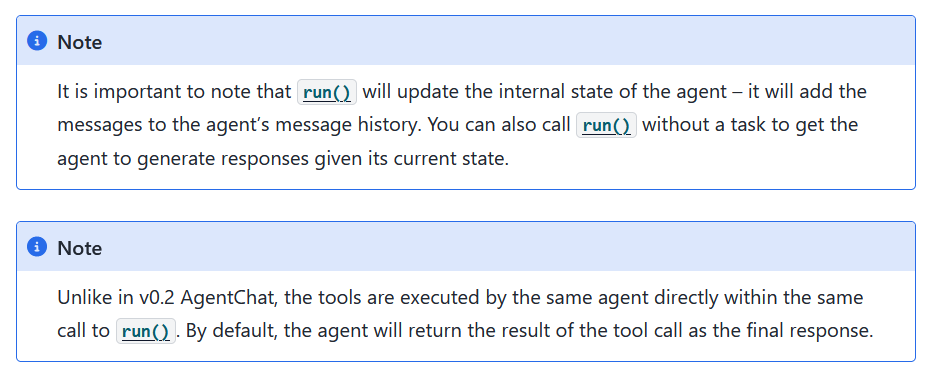

### 1.2) Passing Multi-Modal input to the same AssistantAgent

First let us check out the image


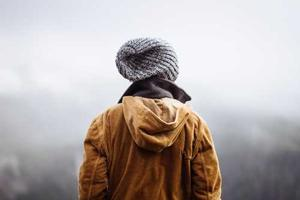

In [18]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

Passing and retrieving results

In [19]:
result3 = await agent.run(task=multi_modal_message)
print(result3)

messages=[MultiModalMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 30, 10, 358865, tzinfo=datetime.timezone.utc), content=['Can you describe the content of this image?', <autogen_core._image.Image object at 0x000001FC0BFD9820>], type='MultiModalMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=317, completion_tokens=50), metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 30, 46, 221407, tzinfo=datetime.timezone.utc), content='This image shows a person wearing a gray knit hat and a brown jacket with a hood. The person is facing away from the camera, and the background appears to be an outdoor scene with a cloudy sky, suggesting a cold or overcast day.', type='TextMessage')] stop_reason=None


### <u>We can also stream each message as the agent returns it</u>

Use the **.run_stream** method for that along with **autogen_agentchat.ui.Console**

In [25]:
await Console(
    agent.run_stream(task="Find information on AutoGen"),
    output_stats=True,  # Enable stats printing.
)

---------- TextMessage (user) ----------
Find information on AutoGen
---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_Z8CeamCyHkiL0AyQ7EENjERb', arguments='{"query": "AutoGen"}', name='web_search'), FunctionCall(id='call_IU2JWvHilvwhZT7nbrF2ehU3', arguments='{"query": "AutoGen framework"}', name='web_search')]
[Prompt tokens: 380, Completion tokens: 47]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_Z8CeamCyHkiL0AyQ7EENjERb', is_error=False), FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search', call_id='call_IU2JWvHilvwhZT7nbrF2ehU3', is_error=False)]
---------- ToolCallSummaryMessage (assistant) ----------
AutoGen is a programming framework for building multi-agent applications.
AutoGen is a programming framework for building multi-

TaskResult(messages=[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 36, 48, 222250, tzinfo=datetime.timezone.utc), content='Find information on AutoGen', type='TextMessage'), ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=380, completion_tokens=47), metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 36, 50, 496860, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_Z8CeamCyHkiL0AyQ7EENjERb', arguments='{"query": "AutoGen"}', name='web_search'), FunctionCall(id='call_IU2JWvHilvwhZT7nbrF2ehU3', arguments='{"query": "AutoGen framework"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 3, 16, 36, 50, 502287, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_sea

The **run_stream** method returns an asynchronous generator that yeilds each message generated by the agent, followed by **TaskResult** as the last item.

#### <u>Breakdown of what happened above followed by notes</u>

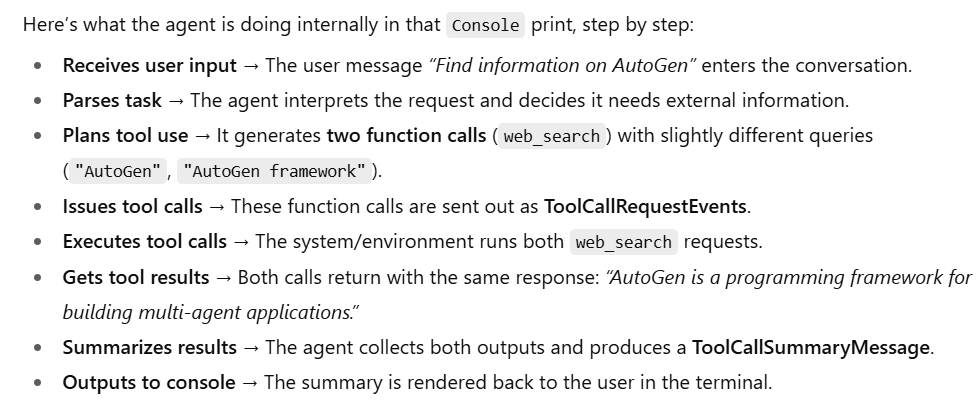

<u>Notes</u>
1. ***Parses task*** -> Agent will compile the below information into a prompt and send to openai (& receive result)
   - User message : "Find information on autogen"
   - System message
   - List of available tools
   - Recent conversation history
2. ***Plans tool use*** -> This was returned by the LLM call in 1. hence it parsed it out and now proceeding to run the 2 web_search calls
3. ***Issues tool calls*** -> **ToolCallRequestEvent** is wrapped around these 2 calls (this is part of the **autogen-core** protocol)
4. ***Execute and get tool results*** -> Since web_search is a python function tool, it executes in the same jupyter environment and returns results which are immediately wrapped into **ToolCallSummaryMessage**

### Again testing if agent is storing history

In [ ]:
await agent.run(task="Can you print all the history of your conversations till now?")

## <u>Using tools and workbench</u>

Modern LLMs are increasingly developing the ability to do **tool calling** i.e. taken in a schema of the tool/function and it's arguements and output the **function call**.

**AssitantAgent** can use tools. *web_search* was 1 such example - it was a custom tool (python function). 

We can either create custom function using python function or subclass the **BaseTool** class.

**Workbench** is a collection of tools that can share state and resources. [Advanced concept so need to look at it again later]

By default **AssistantAgent** runs the tool and returns the response as a string in a **ToolCallSummaryMessage**. 

If our tool does not response with a string, we can use the ***reflect_on_tool_use=True*** option so that the response gets converted well to a string.

### <u>Built-in tools & workbench</u>

Autogen Ext provides a bunch of built-in tools.

### <u>Function tool</u>

If a python function is passed to the assistant agent, agent automatically converts it to a **FunctionTool** class under the hood. (illustrated below).

**FunctionTool** class object has an underlying **function call schema** which is required in all LLMs today.

In [1]:
from autogen_core.tools import FunctionTool

async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework."

# Below step is automatically performed by the agent
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")

print(type(web_search_function_tool))
print(web_search_function_tool.schema)

<class 'autogen_core.tools._function_tool.FunctionTool'>
{'name': 'web_search_func', 'description': 'Find information on the web', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'query', 'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'additionalProperties': False}, 'strict': False}


### MCP Workbench

Getting error - skipping for now

In [4]:
"""
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# Create an MCP workbench which provides a session to the mcp server.
async with McpWorkbench(fetch_mcp_server) as workbench:  # type: ignore
    # Create an agent that can use the fetch tool.
    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")
    fetch_agent = AssistantAgent(
        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True
    )

    # Let the agent fetch the content of a URL and summarize it.
    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
    assert isinstance(result.messages[-1], TextMessage)
    print(result.messages[-1].content)

    # Close the connection to the model client.
    await model_client.close()
"""

'\nfrom autogen_agentchat.agents import AssistantAgent\nfrom autogen_agentchat.messages import TextMessage\nfrom autogen_ext.models.openai import OpenAIChatCompletionClient\nfrom autogen_ext.tools.mcp import McpWorkbench, StdioServerParams\n\n# Get the fetch tool from mcp-server-fetch.\nfetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])\n\n# Create an MCP workbench which provides a session to the mcp server.\nasync with McpWorkbench(fetch_mcp_server) as workbench:  # type: ignore\n    # Create an agent that can use the fetch tool.\n    model_client = OpenAIChatCompletionClient(model="gpt-4.1-nano")\n    fetch_agent = AssistantAgent(\n        name="fetcher", model_client=model_client, workbench=workbench, reflect_on_tool_use=True\n    )\n\n    # Let the agent fetch the content of a URL and summarize it.\n    result = await fetch_agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")\n    assert isinstance(result.messages[-1], TextMes

### <u>Agent as a tool</u>

Any class that inherits from **BaseChatAgent** can be used as a *tool* by wrapping **AgentTool**. 

This allows for multi-agent workflows as one agent can refer to another agent as a tool to solve tasks.

### <u>Parallel tool calls</u>

*Many LLMs support returning multiple tool calls at a time.*

I asked chatgpt for clarification. Below is how an LLM will return a tool call for prompt. Prompt & tool call 1 below another.

<u>prompt</u>

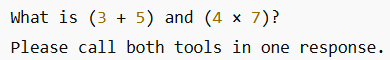

<u>tool call response</u>

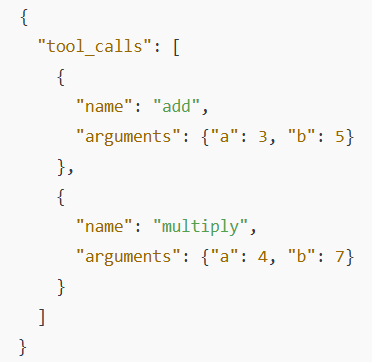

**AssistantAgent** will react positively to more than 1 tool call response by an LLM. 

We can disable this behavior if we do not want parallel tool calls. 

<u>IMPORTANT</u>: Note that this is done at the **model client level** i.e. we tell the LLM to not return more than 1 tool call. The example of **Console(run.stream)** in this same notebook above has an LLM returning 2 tool calls and agent executing 2 tool calls (default behavior).

For **OpenAIChatCompletionClient** or **AzureOpenAIChatCompletionClient**, set ***parallel_tool_calls=False*** to tell the LLM to always return only 1 tool call.

**<u>Note</u>**

We **must mandatorily** disable parallel tool calls when we use **AgentTool** or **TeamTool**.

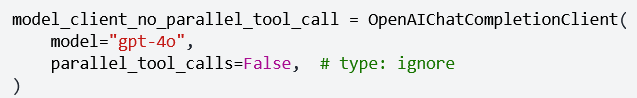

In [ ]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
    parallel_tool_calls=False,  # type: ignore
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

### <u>Tool Iteration</u>

By default, AssistantAgent executes only **1 tool iteration.**

Ex : Imaging that your agent has 5 websearch tools, 1 of them is linkedin search. Then, below would constitute 1 iteration.

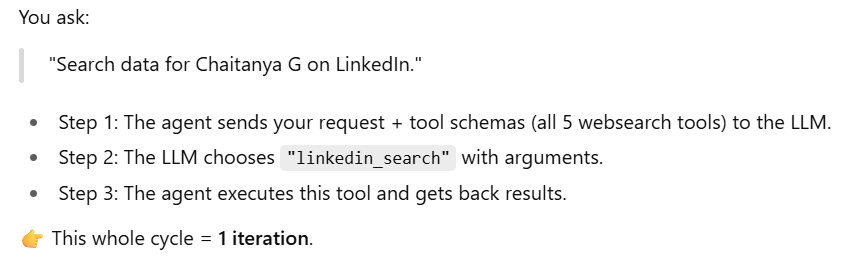

Hence, 1 iteration = **User query -> Model -> tool selection -> agent executes -> agent returns result**

Use **max_tool_iterations** to extend this.

In [ ]:
agent_loop = AssistantAgent(
    name="assistant_loop",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    max_tool_iterations=10,  # At most 10 iterations of tool calls before stopping the loop.
)

### <u>Structured output</u>

To get a structured output from the **AssistantAgent**, we create a **pydantic BaseModel** in **output_content_type** parameter.

Once this is done -> **AssistantAgent** responds with an output of type **StructuredMessage**. 

**StructredMessage.content** is of the custom pydantic basemodel we provided.

<u>Note:</u>


When **output_content_type** is set, by default **reflect_on_tool_use** is set to True so that if the output is not structured, the additional step converts it to structured. If you don't want that then explicitly set reflect on tool use to false so that the output content type directly receives and outputs the value provided by the LLM.

<u>IMPORTANT:</u>

The naming **reflect_on_tool_use** is slightly misleading. 

It is not **reflect_on_tool_use** but in addition doing - **reflect_if_output_not_structured** (when **output_content_type** is set).

See below for chatgpt clarification.

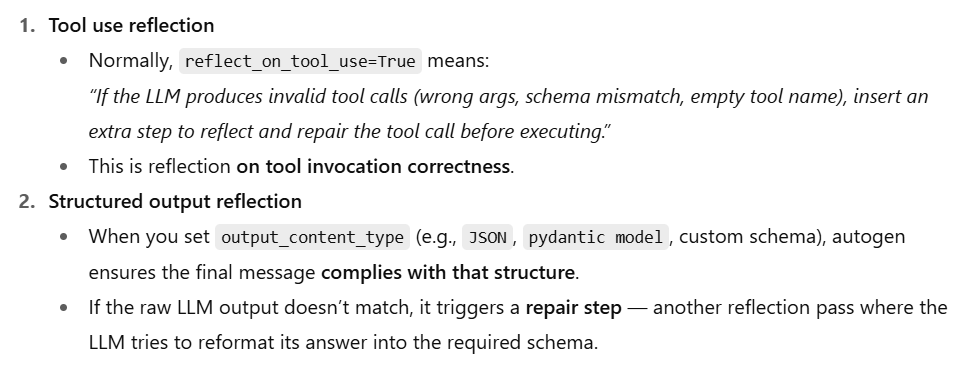

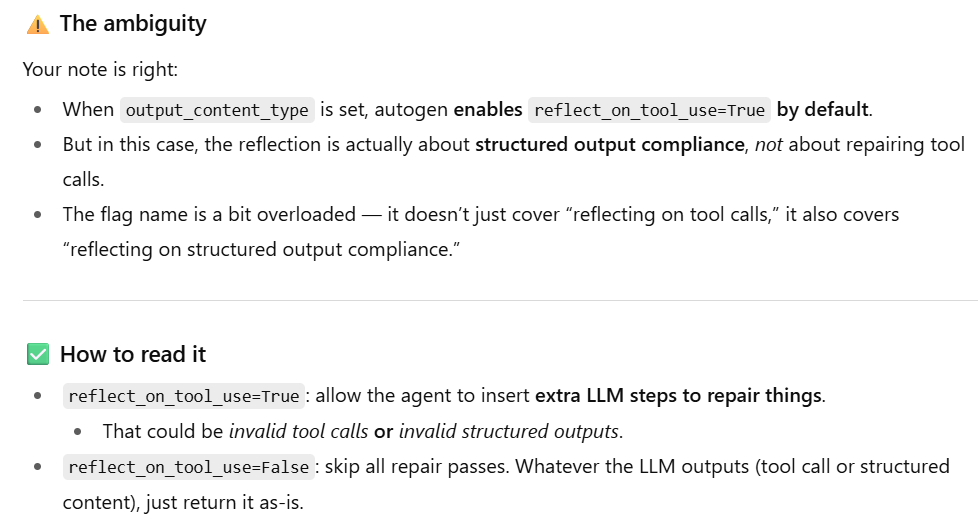

In [ ]:
from typing import Literal
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.ui import Console
from pydantic import BaseModel
from autogen_agentchat.agents import AssistantAgent


# The response format for the agent as a Pydantic base model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
    # Define the output content type of the agent.
    output_content_type=AgentResponse,
)

result = await Console(agent.run_stream(task="I am happy."))

In [3]:
result.messages

[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 7, 11, 52, 20, 367377, tzinfo=datetime.timezone.utc), content='I am happy.', type='TextMessage'),
 StructuredMessage[AgentResponse](source='assistant', models_usage=RequestUsage(prompt_tokens=89, completion_tokens=18), metadata={}, created_at=datetime.datetime(2025, 9, 7, 11, 52, 22, 799935, tzinfo=datetime.timezone.utc), content=AgentResponse(thoughts='The user explicitly states that they are feeling happy.', response='happy'), format_string=None, type='StructuredMessage[AgentResponse]')]

In [8]:
result.messages[-1].content

AgentResponse(thoughts='The user explicitly states that they are feeling happy.', response='happy')

### done till structured output